In [1]:
#import data 
import pandas as pd
import openpyxl
import numpy as np
import scipy.stats
import statsmodels.api as sm
filename = 'weeklydata.xlsx'
xls = pd.ExcelFile(filename)
Return = pd.read_excel(xls)
Return = Return.dropna(axis = 0)
Return = Return.set_index('DATES')
ReturnStock = Return.iloc[0:,0:2]
Riskfree = Return.iloc[0:,2]
simpleReturnA = ReturnStock.iloc[:,0]/ReturnStock.iloc[:,0].shift()-1
simpleReturnB = ReturnStock.iloc[:,1]/ReturnStock.iloc[:,1].shift()-1
simpleReturnA = simpleReturnA.iloc[0:,]
simpleReturnB = simpleReturnB.iloc[0:,]
ReturnRiskfree = Riskfree[0:,]/(52*100)

simple_ReturnStock = pd.concat([simpleReturnA,simpleReturnB],axis = 1).fillna(0)

In [2]:
simpleReturnA

DATES
2001-01-01         NaN
2001-01-08   -0.004574
2001-01-15   -0.000985
2001-01-22   -0.002616
2001-01-29   -0.004975
                ...   
2021-11-29   -0.035182
2021-12-06    0.005379
2021-12-13    0.010760
2021-12-20   -0.011525
2021-12-27    0.041258
Name: MSCI EUROPE U$ - TOT RETURN IND, Length: 1096, dtype: float64

In [3]:
simpleReturnB

DATES
2001-01-01         NaN
2001-01-08   -0.000566
2001-01-15   -0.047491
2001-01-22    0.051005
2001-01-29   -0.010464
                ...   
2021-11-29   -0.033558
2021-12-06   -0.005008
2021-12-13    0.015896
2021-12-20   -0.016513
2021-12-27    0.013791
Name: MSCI PACIFIC U$ - TOT RETURN IND, Length: 1096, dtype: float64

In [4]:
simpleReturnA_mean = simpleReturnA.mean()
simpleReturnB_mean = simpleReturnB.mean()
ReturnRiskfree_mean = ReturnRiskfree.mean()

simpleReturnA_std = simpleReturnA.std()
simpleReturnB_std = simpleReturnB.std()
ReturnRiskfree_std = ReturnRiskfree.std()

In [5]:
# Expected returns, annualized
AnnualizedA = ((1+simpleReturnA_mean)**52)-1
AnnualizedB = ((1+simpleReturnB_mean)**52)-1
AnnualizedRiskfree = ((1+ReturnRiskfree_mean)**52)-1
R_s_std_ann = simpleReturnA_std*np.sqrt(52)
R_b_std_ann = simpleReturnB_std*np.sqrt(52)
R_f_std_ann = ReturnRiskfree_std*np.sqrt(52)

In [6]:
sigma = np.cov(simpleReturnA[1:],simpleReturnB[1:])
inv_sigma = np.linalg.inv(sigma)

In [7]:
inv_sigma

array([[ 2177.25289694, -1679.47224028],
       [-1679.47224028,  2736.2805114 ]])

In [8]:
Lambda = np.array([[2],[10]])
mu = np.matrix([simpleReturnA_mean,simpleReturnB_mean])
e = np.matrix([1,1])
alpha_2 = np.multiply(1/Lambda[0],np.dot(inv_sigma, mu.T - e.T * ReturnRiskfree_mean))
alpha_10 = np.multiply(1/Lambda[1],np.dot(inv_sigma, mu.T - e.T * ReturnRiskfree_mean))

In [9]:
w_R_f_lambda_2 = 1 - np.sum(alpha_2)
w_R_f_lambda_10= 1 - np.sum(alpha_10)

In [10]:
w_lambda_2 = [alpha_2[0],alpha_2[1], w_R_f_lambda_2]
w_lambda_10 = [alpha_10[0],alpha_10[1], w_R_f_lambda_10]

In [11]:
w_lambda_2

[matrix([[0.4027427]]), matrix([[0.41845222]]), 0.17880508873927137]

In [12]:
ReturnA_excess = simpleReturnA - ReturnRiskfree
ReturnA_excess = ReturnA_excess.iloc[1:,]
ReturnB_excess = simpleReturnB - ReturnRiskfree 
ReturnB_excess = ReturnB_excess.iloc[1:,]
squaredA = np.square(ReturnA_excess)
squaredB = np.square(ReturnB_excess)

In [13]:
def KSTest_Gaussian(x):
    # Computes the KS test by empirically comparing cumulated distribution functions
    xs = np.sort(x)
    data_ecdf = np.arange(1, len(xs)+1)/float(len(xs))    
    Gaussian_cdf=scipy.stats.norm.cdf(xs,np.mean(x),np.std(x))
   # Test
    err=abs(data_ecdf-Gaussian_cdf)
    max_err=np.max(err)
    critical=1.36/np.power(len(x),0.5); # KS test threshold for 5% test
    return (max_err,critical)  

def LjungBoxQ(x,lag):
    T=len(x)
    Formatedx=pd.Series(x)
    output=[]
    critical_values=[]
    for i_lag in range(1,lag):
        temp=0
        for i in range(1,i_lag):
            temp+=1/(T-i+1)*np.power(Formatedx.autocorr(i),2)
        output+=[temp*T*(T+2)]
        critical_values+=[scipy.stats.chi2.isf(.05,i_lag)]
    return pd.DataFrame([output, critical_values])


In [14]:
kstestA = KSTest_Gaussian(ReturnA_excess)
kstestb = KSTest_Gaussian(ReturnB_excess)
kstestSquareA  = KSTest_Gaussian(squaredA)
kstestSquareB = KSTest_Gaussian(squaredB)
data = {'A excess':kstestA,'B excess':kstestb,'A squared excess':kstestSquareA,'B squared excess':kstestSquareB}
results2 = pd.DataFrame(data)
print(results2)
#All of them are higher  than the critical value, so we reject the normality hypothesis


   A excess  B excess  A squared excess  B squared excess
0  0.090771  0.063601          0.356018          0.346453
1  0.041099  0.041099          0.041099          0.041099


In [15]:
ljungA = LjungBoxQ(ReturnA_excess,4)
ljungb = LjungBoxQ(ReturnB_excess,4)
ljungSquareA  = LjungBoxQ(squaredA,4)
ljungSquareB = LjungBoxQ(squaredB,4)
results = pd.concat([ljungA,ljungb,ljungSquareA,ljungSquareB],axis = 1)
#In the order, we have 3 results for LjungBox test for ReturnExcessA, then B, then squared A, then squared B
results


,0,1,2,0,1,2,0,1,2,0,1,2
0,0.000000,2.315472,7.392599,0.000000,4.860395,5.023407,0.000000,89.713681,178.392151,0.000000,93.009842,277.077774
1,3.841459,5.991465,7.814728,3.841459,5.991465,7.814728,3.841459,5.991465,7.814728,3.841459,5.991465,7.814728


<AxesSubplot:xlabel='DATES'>

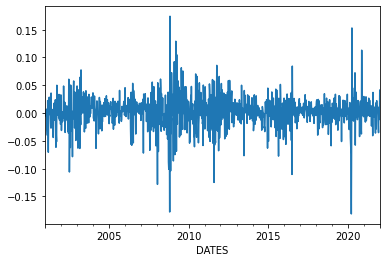

In [16]:
simpleReturnA.plot()

<AxesSubplot:xlabel='DATES'>

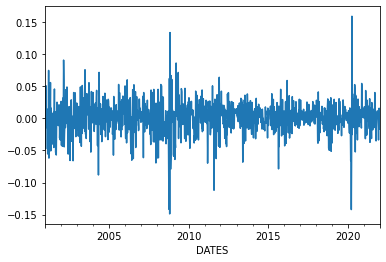

In [17]:
simpleReturnB.plot()

In [18]:
simple_ReturnStock

,MSCI EUROPE U$ - TOT RETURN IND,MSCI PACIFIC U$ - TOT RETURN IND
DATES,,
2001-01-01,0.000000,0.000000
2001-01-08,-0.004574,-0.000566
2001-01-15,-0.000985,-0.047491
2001-01-22,-0.002616,0.051005
2001-01-29,-0.004975,-0.010464
...,...,...
2021-11-29,-0.035182,-0.033558
2021-12-06,0.005379,-0.005008
2021-12-13,0.010760,0.015896


In [19]:
dfA = simple_ReturnStock.reset_index()
y = dfA.iloc[1:,1].reset_index()
y = y['MSCI EUROPE U$ - TOT RETURN IND']
x = dfA.iloc[0:len(dfA)-1,2]
x = sm.add_constant(x)
modelA = sm.OLS(y,x)
resultsA = modelA.fit()

In [20]:
resultsA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     MSCI EUROPE U$ - TOT RETURN IND   R-squared:                       0.005
Model:                                         OLS   Adj. R-squared:                  0.004
Method:                              Least Squares   F-statistic:                     4.975
Date:                             Thu, 26 May 2022   Prob (F-statistic):             0.0259
Time:                                     18:20:50   Log-Likelihood:                 2306.1
No. Observations:                             1095   AIC:                            -4608.
Df Residuals:                                 1093   BIC:                            -4598.
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.0015      0.001      1.725      0.085      -0.000       0.003
MSCI PACIFIC U$ - TOT RETURN IND    -0.0755      0.034     -2.231      0.026      -0.142      -0.009
==============================================================================
Omnibus:                      171.826   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1292.184
Skew:                          -0.486   Prob(JB):                    2.55e-281
Kurtosis:                       8.232   Cond. No.                         38.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
df = simple_ReturnStock.reset_index()
y_b = df.iloc[1:,2].reset_index()
y_b = y_b['MSCI PACIFIC U$ - TOT RETURN IND']
x_b = df.iloc[0:len(df)-1,2]
x_b = sm.add_constant(x_b)
modelB = sm.OLS(y_b,x_b)
resultsB = modelB.fit()

In [22]:
resultsB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     MSCI PACIFIC U$ - TOT RETURN IND   R-squared:                       0.005
Model:                                          OLS   Adj. R-squared:                  0.004
Method:                               Least Squares   F-statistic:                     5.016
Date:                              Thu, 26 May 2022   Prob (F-statistic):             0.0253
Time:                                      18:20:51   Log-Likelihood:                 2431.2
No. Observations:                              1095   AIC:                            -4858.
Df Residuals:                                  1093   BIC:                            -4848.
Df Model:                                         1                                         
Covariance Type:                          nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.0014      0.001      1.747      0.081      -0.000       0.003
MSCI PACIFIC U$ - TOT RETURN IND    -0.0676      0.030     -2.240      0.025      -0.127      -0.008
==============================================================================
Omnibus:                      155.564   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              976.813
Skew:                          -0.472   Prob(JB):                    7.72e-213
Kurtosis:                       7.530   Cond. No.                         38.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
betas = np.linalg.inv(x.transpose().dot(x)).dot(x.transpose()).dot(y)
betasB = np.linalg.inv(x_b.transpose().dot(x_b)).dot(x_b.transpose()).dot(y_b)
y_hat = x.dot(betas)
yB_hat = x_b.dot(betasB)
est_AR_1_process_A = y_hat 
est_AR_1_process_B = yB_hat 
residA = np.array(resultsA.resid)
residB = np.array(resultsB.resid)


In [24]:
len(est_AR_1_process_A)

1095

In [25]:
# Estimation of a GARCH model for Residuals of index A
from scipy.optimize import fmin_slsqp
def garch_likelihoodA(parametersA, y, sigma2, out=None):
    #Returns negative likelihood for GARCH(1,1) model
    muA = parametersA[0]
    omegaA = parametersA[1]
    alphaA = parametersA[2]
    betaA = parametersA[3]
    
    
    TA = np.size(y,0)
    epsA = y - muA
    # Data and sigma2 are T by 1 vectors
    for t in range(1,TA):
        sigma2[t] = (omegaA + alphaA * epsA[t-1]**2 
                     + betaA * sigma2[t-1])
    
    logliksA = 0.5*(np.log(2*np.pi) + np.log(sigma2) + epsA**2/sigma2)
    loglikA = sum(logliksA)
    
    
    global vol_histA
    vol_histA=np.sqrt(sigma2)
    
    if out is None:
        return loglikA
    else:
        return loglikA, logliksA, np.copy(sigma2)

In [26]:
def garch_constraintA(parameters, y, sigma2, out=None):
    ''' Constraint that alpha+beta<1'''
    alphaA = parameters[2]
    betaA = parameters[3]
    return np.array([1-alphaA-betaA])

startingValsA = np.array([y.mean(),
                      y.var() * .01,
                      .03, .9])

finfoA = np.finfo(np.float64)
boundsA = [(-10*y.mean(), 10*y.mean()),
          (finfoA.eps, 2*y.var() ),
          (0.0,1.0), (0.0,1.0)]
       
TA = y.shape[0]
sigma2 = np.ones(TA) * y.var()
# Pass a NumPy array, not a pandas Series
argsA = (np.asarray(y), sigma2)

estimatesA = fmin_slsqp(garch_likelihoodA, startingValsA, f_ieqcons=garch_constraintA, bounds = boundsA,args = argsA)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2411.833303880094
            Iterations: 6
            Function evaluations: 15
            Gradient evaluations: 2


In [27]:
estimatesA
#In the order, the values given are : mu, omega, alpha, beta

array([1.72955002e-03, 4.73242509e-05, 5.15709625e-02, 9.02223811e-01])

In [28]:
# Estimation of a GARCH model for Residuals of index B
from scipy.optimize import fmin_slsqp
def garch_likelihoodB(parametersB, y_b, sigma3, out=None):
    #Returns negative likelihood for GARCH(1,1) model
    muB = parametersB[0]
    omegaB = parametersB[1]
    alphaB = parametersB[2]
    betaB = parametersB[3]
    
    
    TB = np.size(y_b,0)
    epsB = y_b - muB
    # Data and sigma2 are T by 1 vectors
    for t in range(1,TB):
        sigma3[t] = (omegaB + alphaB * epsB[t-1]**2 
                     + betaB * sigma2[t-1])
    
    logliksB = 0.5*(np.log(2*np.pi) + np.log(sigma3) + epsB**2/sigma3)
    loglikB = sum(logliksB)
    
    
    global vol_histB
    vol_histB=np.sqrt(sigma3)
    
    if out is None:
        return loglikB
    else:
        return loglikB, logliksB, np.copy(sigma3)

In [29]:
def garch_constraintB(parametersB, y_b, sigma3, out=None):
    ''' Constraint that alpha+beta<1'''
    alphaB = parametersB[2]
    betaB = parametersB[3]
    return np.array([1-alphaB-betaB])

startingValsB = np.array([y_b.mean(),
                      y_b.var() * .01,
                      .03, .6])

finfoB = np.finfo(np.float64)
boundsB = [(-10*y_b.mean(), 10*y_b.mean()),
          (finfoB.eps, 2*y_b.var() ),
          (0.0,1.0), (0.0,1.0)]
       
TB = y_b.shape[0]
sigma3 = np.ones(TB) * y_b.var()
# Pass a NumPy array, not a pandas Series
argsB = (np.asarray(y_b), sigma3)

estimatesB = fmin_slsqp(garch_likelihoodB, startingValsB, f_ieqcons=garch_constraintB, bounds = boundsB,args = argsB)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2515.7549715471882
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11


In [30]:
estimatesB
#In the order, the values given are : mu, omega, alpha, beta

array([2.02179836e-03, 5.30872946e-12, 2.26043019e-01, 5.65467178e-01])

Parameter   Estimate       Std. Err.      T-stat
mu          0.001730        0.001104     1.56640
omega       0.000047        0.000012     4.00434
alpha       0.051571        0.006411     8.04390
beta        0.902224        0.016705     54.00775


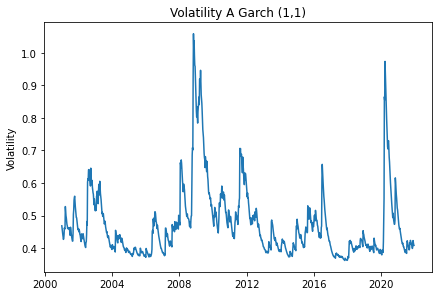

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
import matplotlib.axes as ax 
stepA = 1e-5 * estimatesA
scoresA = np.zeros((TA,4))
for i in range(4):
    hA = stepA[i]
    deltaA = np.zeros(4)
    deltaA[i] = hA
    
    loglikA, logliksplusA, sigma2 = garch_likelihoodA(estimatesA + deltaA,np.asarray(residA), sigma2, out=True)
    loglikA, logliksminusA, sigma2 = garch_likelihoodA(estimatesA - deltaA,np.asarray(residA), sigma2, out=True)                   
               
    scoresA[:,i] = (logliksplusA - logliksminusA)/(2*hA)

IA = (scoresA.T @ scoresA)/TA    
vcvA=np.mat(np.linalg.inv(IA))/TA
vcvA = np.asarray(vcvA)

output = np.vstack((estimatesA,np.sqrt(np.diag(vcvA)),(estimatesA)/np.sqrt(np.diag(vcvA)))).T    
print('Parameter   Estimate       Std. Err.      T-stat')
param = ['mu','omega','alpha','beta']
for i in range(len(param)):
    print('{0:<11} {1:>0.6f}        {2:0.6f}    {3: 0.5f}'.format(param[i],
           output[i,0], output[i,1], output[i,2]))


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Produce a plot
dates = ReturnStock.index[0:len(ReturnStock)-1]
plt.plot(dates,(vol_histA)*np.sqrt(252))
plt.tight_layout()
plt.ylabel('Volatility')
plt.title('Volatility A Garch (1,1)')
plt.show()
plt.savefig('Volatility A Garch (1,1)')
## Volatility is given with 1e-5 power, find a way to fix this !

Parameter   Estimate       Std. Err.      T-stat
mu          0.002022        0.000690     2.92988
omega       0.000000        0.000063     0.00000
alpha       0.226043        0.032335     6.99058
beta        0.565467        0.083898     6.73991


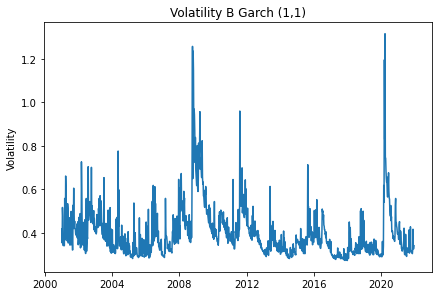

<Figure size 432x288 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt
import matplotlib.axes as ax 
stepB = 1e-5 * estimatesB
scoresB = np.zeros((TB,4))
for i in range(4):
    hB = stepB[i]
    deltaB = np.zeros(4)
    deltaB[i] = hB
    
    loglikB, logliksplusB, sigma3 = garch_likelihoodB(estimatesB + deltaB,np.asarray(residB), sigma3, out=True)
    loglikB, logliksminusB, sigma3 = garch_likelihoodB(estimatesB - deltaB,np.asarray(residB), sigma3, out=True)                   
               
    scoresB[:,i] = (logliksplusB - logliksminusB)/(2*hB)

Ib = (scoresB.T @ scoresB)/TB    
vcvB=np.mat(np.linalg.inv(Ib))/TB
vcvB = np.asarray(vcvB)

outputB = np.vstack((estimatesB,np.sqrt(np.diag(vcvB)),(estimatesB)/np.sqrt(np.diag(vcvB)))).T    
print('Parameter   Estimate       Std. Err.      T-stat')
paramB = ['mu','omega','alpha','beta']
for i in range(len(paramB)):
    print('{0:<11} {1:>0.6f}        {2:0.6f}    {3: 0.5f}'.format(paramB[i],
           outputB[i,0], outputB[i,1], outputB[i,2]))


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Produce a plot
dates = simple_ReturnStock.index[0:len(ReturnStock)-1]
plt.plot(dates,(vol_histB)*np.sqrt(252))
plt.tight_layout()
plt.ylabel('Volatility')
plt.title('Volatility B Garch (1,1)')
plt.show()
plt.savefig('Volatility B Garch (1,1)')
## Volatility is given with 1e-5 power, find a way to fix this !

In [33]:
## Part 3 -
sigma_t = np.zeros([2,2])
mu_t = np.zeros([2,1])
residuals = {'residuals A': residA, 'residuals B':residB}
residualsdf = pd.DataFrame(residuals)
residualsdf.set_index(simple_ReturnStock[1:].index)


,residuals A,residuals B
DATES,,
2001-01-08,-0.006112,-0.001956
2001-01-15,-0.002566,-0.048919
2001-01-22,-0.007739,0.046405
2001-01-29,-0.002664,-0.008406
2001-02-05,0.004585,-0.012615
...,...,...
2021-11-29,-0.037653,-0.035782
2021-12-06,0.001308,-0.008666
2021-12-13,0.008843,0.014168


/var/folders/ry/1ys1rz9n22ldsnzc8jsq9gqh0000gn/T/ipykernel_39906/426423778.py:23: UserWarning: Legend does not support 'u' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('unconditional var', 'forecasted cond. var')
/var/folders/ry/1ys1rz9n22ldsnzc8jsq9gqh0000gn/T/ipykernel_39906/426423778.py:23: UserWarning: Legend does not support 'n' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('unconditional var', 'forecasted cond. var')
/var/folders/ry/1ys1rz9n22ldsnzc8jsq9gqh0000gn/T/ipykernel_39906/426423778.py:23: UserWarning: Legend does not support 'c' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists

Text(0.5, 1.0, 'forecasted conditional var, 5 years: Stock')

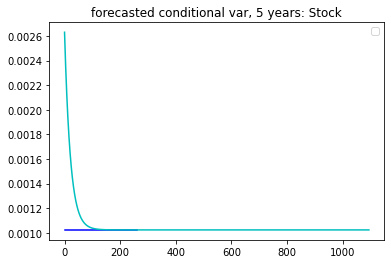

In [34]:
forecasted_var_A = np.ones(len(residA))
omegaA = estimatesA[1]
alphaA = estimatesA[2]
betaA = estimatesA[3]
unconditional_variance_A = omegaA/(1-alphaA-betaA)
uncond_var = np.tile(unconditional_variance_A,(260,1))
forecasted_var_A[0] = omegaA + alphaA*residA[-1] + betaA*sigma2[-1]
for i in range(1,len(residA)):
    forecasted_var_A[i] = omegaA + (alphaA+betaA)*forecasted_var_A[i-1]
#We do the same for index B 
forecasted_var_B = np.ones(len(residB))
omegaB = estimatesB[1]
alphaB = estimatesB[2]
betaB = estimatesB[3]
unconditional_variance_B = omegaB/(1-alphaB-betaB)
uncond_varB = np.tile(unconditional_variance_B,(260,1))
forecasted_var_B[0] = omegaB + alphaB*residB[-1] + betaB*sigma3[-1]
for i in range(1,len(residA)):
    forecasted_var_B[i] = omegaB + (alphaB+betaB)*forecasted_var_B[i-1]
#Plotting 260 (5 years) to show the convergence
plt.plot(uncond_var,'b')
plt.plot(forecasted_var_A,'c')
plt.legend('unconditional var', 'forecasted cond. var')
plt.title('forecasted conditional var, 5 years: Stock')

In [35]:
corrAB  = np.corrcoef(residualsdf['residuals A'],residualsdf['residuals B'])[0][1] #This function gives us a matrix with values of correlation 
#between residA and residB, so we only keep the correlation between them and not corr(residA,residA) or corr(residB,residB)
print('The correlation between the 2 residuals is', np.round(corrAB,3))

The correlation between the 2 residuals is 0.687


In [37]:
#Not 100% sure on sigma_t
Lambda = np.zeros((2,1))
Lambda[0] = 2
Lambda[1] = 10
e = np.zeros([1,2])
e[0][0] = 1
e[0][1] = 1
optimal_garch_weights_alpha_2 = np.zeros((len(est_AR_1_process_A),2))
optimal_garch_weights_alpha_10 = np.zeros((len(est_AR_1_process_A),2))
for i in range(len(est_AR_1_process_A)):
    sigma_t[0][0] = sigma2[i]
    sigma_t[0][1] = corrAB * np.sqrt(sigma2[i])*np.sqrt(sigma3[i])
    sigma_t[1][0] = corrAB * np.sqrt(sigma2[i])*np.sqrt(sigma3[i])
    sigma_t[1][1] = sigma3[i]
    mu_t[0][0] = est_AR_1_process_A[i]
    mu_t[1][0] = est_AR_1_process_B[i]

    optimal_garch_weights_alpha_2[i,:] = np.multiply(1/Lambda[0],np.dot(np.linalg.inv(sigma_t), mu_t - e.T * ReturnRiskfree[i])).T
    optimal_garch_weights_alpha_10[i,:] = np.multiply(1/Lambda[1],np.dot(np.linalg.inv(sigma_t), mu_t - e.T * ReturnRiskfree[i])).T

In [38]:
optimal_weights_garch_rf_2 = np.ones(1095) - optimal_garch_weights_alpha_2[:,0] - optimal_garch_weights_alpha_2[:,1]
optimal_weights_garch_rf_10 = np.ones(1095) - optimal_garch_weights_alpha_10[:,0] - optimal_garch_weights_alpha_10[:,1]
#Verify the results, because with alpha = 2 or 10, we have most of our wealth invested in the riskfree asset
#Verify the formula of the cell just above
#For aplha = 10 it's normal because there is a big risk aversion 

In [39]:
constant_var_A_2 = np.tile(w_lambda_2[0],(len(optimal_garch_weights_alpha_2),1))
constant_var_B_2 = np.tile(w_lambda_2[1],(len(optimal_garch_weights_alpha_2),1))
constant_var_riskfree_2 = np.tile(w_lambda_2[2],(len(optimal_garch_weights_alpha_2),1))

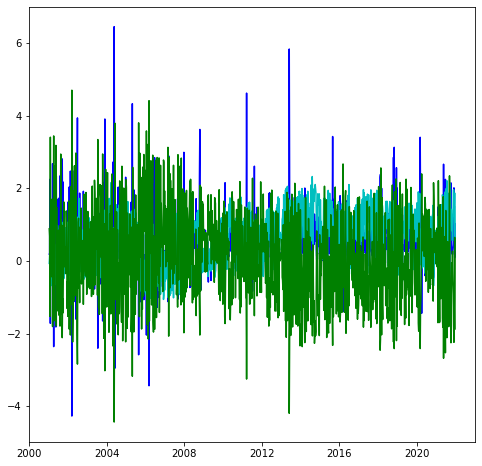

In [40]:
plt.figure(figsize = (8,8))
plt.plot(simple_ReturnStock.index[1:,],optimal_garch_weights_alpha_2[:,0],'b')
plt.plot(simple_ReturnStock.index[1:,],optimal_garch_weights_alpha_2[:,1],'c')
plt.plot(simple_ReturnStock.index[1:,],optimal_weights_garch_rf_2,'g')
plt.savefig('1')

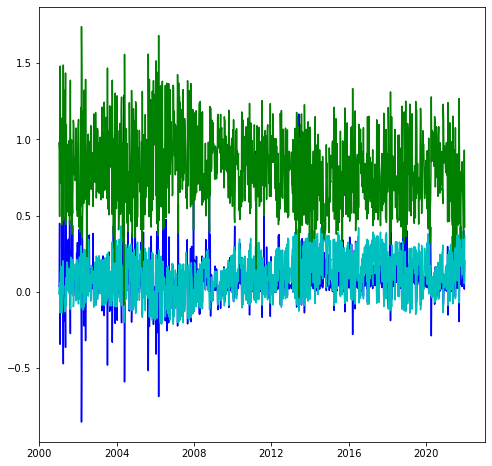

In [41]:
plt.figure(figsize = (8,8))
plt.plot(simple_ReturnStock.index[1:,],optimal_garch_weights_alpha_10[:,0],'b')
plt.plot(simple_ReturnStock.index[1:,],optimal_garch_weights_alpha_10[:,1],'c')
plt.plot(simple_ReturnStock.index[1:,],optimal_weights_garch_rf_10,'g')
plt.savefig('2')

In [42]:
constant_var_A_10 = np.tile(w_lambda_10[0],(len(optimal_garch_weights_alpha_10),1))
constant_var_B_10 = np.tile(w_lambda_10[1],(len(optimal_garch_weights_alpha_10),1))
constant_var_riskfree_10 = np.tile(w_lambda_10[2],(len(optimal_garch_weights_alpha_10),1))

In [43]:
#Computive cumulative portfolio returns for both approaches
Realized_return_A = simpleReturnA[1:]
Realized_return_B = simpleReturnB[1:]
Realized_riskfree = ReturnRiskfree[1:]

Realized_return_df = pd.concat([Realized_return_A,Realized_return_B,Realized_riskfree],axis = 1).fillna(0)


#First Approach - Unconditional Variance
weights_unconditional_2 = np.tile(w_lambda_2,(len(Realized_return_A),1)).T
weights_unconditional_10 = np.tile(w_lambda_10,(len(Realized_return_B),1)).T

#Second Approach - Conditional Variance 
weights_cond_2 = np.matrix([optimal_garch_weights_alpha_2[:,0],optimal_garch_weights_alpha_2[:,1],optimal_weights_garch_rf_2])
weights_cond_10 = np.matrix([optimal_garch_weights_alpha_10[:,0],optimal_garch_weights_alpha_10[:,1],optimal_weights_garch_rf_10])


/Users/saminho/opt/anaconda3/envs/ada/lib/python3.8/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


In [44]:
R = Realized_return_df.values
port_return_2_uncond = np.diag(np.matmul(R,weights_unconditional_2))
port_return_10_uncond = np.diag(np.matmul(R,weights_unconditional_10))

In [45]:
port_return_2_cond = np.diag(np.matmul(R,weights_cond_2[:,0:]))
port_return_10_cond = np.diag(np.matmul(R,weights_cond_10[:,0:]))

In [46]:
port_return_2_uncond = np.array(port_return_2_uncond, dtype = float)
port_return_10_uncond = np.array(port_return_10_uncond, dtype = float)
port_return_2_cond = np.array(port_return_2_cond, dtype = float)
port_return_10_cond = np.array(port_return_10_cond, dtype = float)

In [47]:
simple_portfolio_ret_2  =np.cumprod(1+port_return_2_uncond)
simple_portfolio_ret_10 =np.cumprod(1+port_return_10_uncond)
simple_cum_portfolio_2_cond =np.cumprod(1+port_return_2_cond)
simple_cum_portfolio_10_cond=np.cumprod(1+port_return_10_cond)

In [48]:

port_return_2_uncond_log= np.log(1+port_return_2_uncond)
port_return_10_uncond_log= np.log(1+port_return_10_uncond)
port_return_2_cond_log = np.log(1+port_return_2_cond)
port_return_10_cond_log= np.log(1+port_return_10_cond)

In [49]:
portfolio_ret_w_l_2  =np.cumsum(port_return_2_uncond_log)
portfolio_ret_w_l_10 =np.cumsum(port_return_10_uncond_log)
cum_portfolio_l_2_cond =np.cumsum(port_return_2_cond_log)
cum_portfolio_l_10_cond=np.cumsum(port_return_10_cond_log)

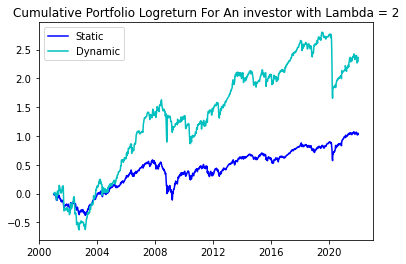

In [50]:
plt.plot(simple_ReturnStock.index[1:], portfolio_ret_w_l_2, 'b',label = 'Static')
plt.plot(simple_ReturnStock.index[1:],cum_portfolio_l_2_cond, 'c',label = 'Dynamic')
plt.legend()
plt.title('Cumulative Portfolio Logreturn For An investor with Lambda = 2')
plt.savefig('Cumulative Portfolio Logreturn For An investor with Lambda = 2')



In [51]:
mean_2_uncond = np.mean(port_return_2_uncond)
mean_2_cond = np.mean(port_return_2_cond)
std_2_uncond = np.std(port_return_2_uncond)
std_2_cond = np.std(port_return_2_cond)
skewness_2_uncond = scipy.stats.skew(port_return_2_uncond)
skewness_2_cond = scipy.stats.skew(port_return_2_cond)
kurtosis_2_uncond = scipy.stats.kurtosis(port_return_2_uncond)
kurtosis_2_cond = scipy.stats.kurtosis(port_return_2_cond)

mean_10_uncond = np.mean(port_return_10_uncond)
mean_10_cond = np.mean(port_return_10_cond)
std_10_uncond = np.std(port_return_10_uncond)
std_10_cond = np.std(port_return_10_cond)
skewness_10_uncond = scipy.stats.skew(port_return_10_uncond)
skewness_10_cond = scipy.stats.skew(port_return_10_cond)
kurtosis_10_uncond = scipy.stats.kurtosis(port_return_10_uncond)
kurtosis_10_cond = scipy.stats.kurtosis(port_return_10_cond)

In [52]:
static_lambda_2 = {'mean':mean_2_uncond,'std':std_2_uncond,'skewness':skewness_2_uncond,'kurtosis':kurtosis_2_uncond}
static_lambda_10 = {'mean':mean_10_uncond,'std':std_10_uncond,'skewness':skewness_10_uncond,'kurtosis':kurtosis_10_uncond}
dynamic_lambda_2 = {'mean':mean_2_cond,'std':std_2_cond,'skewness':skewness_2_cond,'kurtosis':kurtosis_2_cond}
dynamic_lambda_10 = {'mean':mean_10_cond,'std':std_10_cond,'skewness':skewness_10_cond,'kurtosis':kurtosis_10_cond}

summary = pd.DataFrame([static_lambda_2,static_lambda_10,dynamic_lambda_2,dynamic_lambda_10], index = ['static lambda 2','static lambda 10','dynamic lambda 2','dynamic lambda 10'])
summary

,mean,std,skewness,kurtosis
static lambda 2,0.001177,0.021047,-0.453091,6.017929
static lambda 10,0.000467,0.004205,-0.462247,5.932000
dynamic lambda 2,0.003044,0.041363,-0.734703,13.391466
dynamic lambda 10,0.000840,0.008276,-0.735757,13.328772


In [53]:
weights_A_conditional_2 = weights_cond_2[0,:].T
weights_B_conditional_2 = weights_cond_2[1,:].T
weights_A_conditional_10 = weights_cond_10[0,:].T
weights_B_conditional_10 = weights_cond_10[1,:].T

In [54]:
len(weights_B_conditional_2)

1095

In [55]:
#For Lambda = 2, simple return 
TC_t_2_simple = np.array(np.absolute(weights_A_conditional_2[1:,0] - weights_A_conditional_2[0:-1,0]) + np.absolute(weights_B_conditional_2[1:,0] - weights_B_conditional_2[0:-1,0]),dtype = float)
TC_t_2_simple = np.append(TC_t_2_simple,[0])
TC_t_2_simple[1:-1]=TC_t_2_simple[0:-2]
TC_t_2_simple[0] = 0

In [56]:
R1 = port_return_2_cond
C = TC_t_2_simple
A = simple_portfolio_ret_2[-1]

In [57]:
len(C)

1095

In [58]:
from scipy import optimize
def function(x): 
    return np.absolute(np.prod(1+R1-x*C)-A)
tau_2_simple= optimize.fmin(function,0)
tau_2_simple = optimize.fsolve(function,0)
print(tau_2_simple)

Optimization terminated successfully.
         Current function value: 0.000117
         Iterations: 15
         Function evaluations: 30
[0.00077181]


In [59]:
#For lambda = 10 simple return 
TC_t_10_simple = np.array(np.absolute(weights_A_conditional_10[1:,0] - weights_A_conditional_10[0:-1,0]) + np.absolute(weights_B_conditional_10[1:,0] - weights_B_conditional_10[0:-1,0]),dtype = float)
TC_t_10_simple[1:-1]=TC_t_10_simple[0:-2]
TC_t_10_simple = np.append(TC_t_10_simple,[0])
TC_t_10_simple[0] = 0

R2 = port_return_10_cond
C2 = TC_t_10_simple
A2 = simple_portfolio_ret_10[-1]
def function1(x): 
    return np.prod(1+R2-x*C2)-A2
tau_10_simple = optimize.fsolve(function1,0)
print(tau_10_simple)


[0.00111386]


In [60]:
#For lambda = 2 logreturns
TC_t_2_log = np.array(np.absolute(weights_A_conditional_2[1:,0] - weights_A_conditional_2[0:-1,0]) + np.absolute(weights_B_conditional_2[1:,0] - weights_B_conditional_2[0:-1,0]),dtype = float)
TC_t_2_log = np.append(TC_t_2_log,[0])
TC_t_2_log[1:-1]=TC_t_2_log[0:-2]
TC_t_2_log[0] = 0

R3 = port_return_2_cond
C3 = TC_t_2_log
A3 = portfolio_ret_w_l_2[-1]

def function3(x):
    return np.sum(np.log(1+R3-x*C3))-A3
tau_2_log = optimize.fsolve(function3,0)
print(tau_2_log)


[0.00077181]


In [61]:
#For lambda = 10 logreturns 
TC_t_10_log = np.array(np.absolute(weights_A_conditional_10[1:,0] - weights_A_conditional_10[0:-1,0]) + np.absolute(weights_B_conditional_10[1:,0] - weights_B_conditional_10[0:-1,0]),dtype = float)
TC_t_10_log = np.append(TC_t_10_log,[0])
TC_t_10_log[1:-1]=TC_t_10_log[0:-2]
TC_t_10_log[0]=0

R4 = port_return_10_cond
C4 = TC_t_10_log
A4 = portfolio_ret_w_l_10[-1]

def function4(x):
    return np.sum(np.log(1+R4-x*C4))-A4
tau_10_log = optimize.fsolve(function4,0) #Petit problème quand on solve cette fonction là
print(tau_10_log)



[0.00111439]


In [62]:
cum_return_2_TC_simple = np.cumprod(1+port_return_2_cond - tau_2_simple* TC_t_2_simple)
cum_return_10_TC_simple = np.cumprod(1+port_return_10_cond - tau_10_simple*TC_t_10_simple)
cum_return_2_TC_log = np.cumsum(np.log(1+port_return_2_cond - tau_2_log*TC_t_2_log))
cum_return_10_TC_log = np.cumsum(np.log(1+port_return_10_cond - tau_10_log*TC_t_10_log))

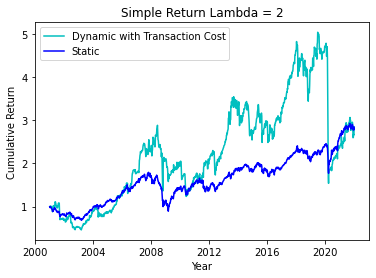

In [63]:
plt.plot(ReturnStock.index[1:,],cum_return_2_TC_simple,'c',label = 'Dynamic with Transaction Cost')
plt.plot(ReturnStock.index[1:,],simple_portfolio_ret_2,'b',label = 'Static')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('Simple Return Lambda = 2')
plt.legend()
plt.savefig('TC Simple Return Lambda = 2')

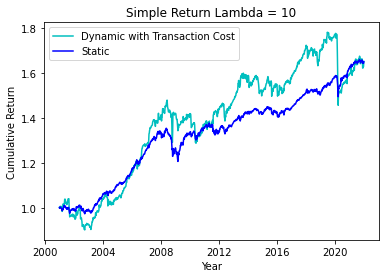

In [64]:
plt.plot(ReturnStock.index[1:,],cum_return_10_TC_simple,'c',label = 'Dynamic with Transaction Cost')
plt.plot(ReturnStock.index[1:,],simple_portfolio_ret_10,'b',label = 'Static')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('Simple Return Lambda = 10')
plt.legend()
plt.savefig('TC Simple Return Lambda = 10')

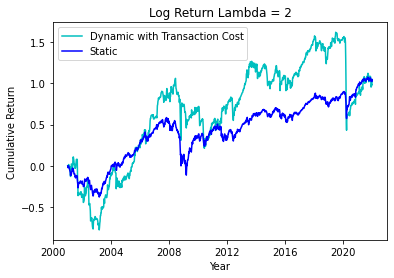

In [65]:
plt.plot(ReturnStock.index[1:,],cum_return_2_TC_log,'c',label = 'Dynamic with Transaction Cost')
plt.plot(ReturnStock.index[1:,],portfolio_ret_w_l_2,'b',label = 'Static')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('Log Return Lambda = 2')
plt.legend()
plt.savefig('TC Log Return Lambda = 2')

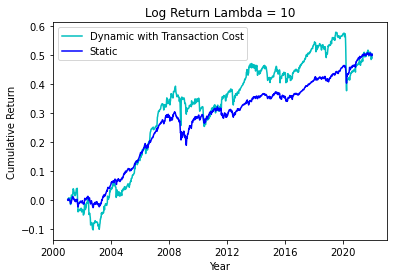

In [66]:
plt.plot(ReturnStock.index[1:,],cum_return_10_TC_log,'c',label = 'Dynamic with Transaction Cost')
plt.plot(ReturnStock.index[1:,],portfolio_ret_w_l_10,'b',label = 'Static')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('Log Return Lambda = 10')
plt.legend()
plt.savefig('TC Log Return Lambda = 10')

In [67]:
#Part-4
# We will now work with the daily data, so we we will create dataframes for the daily data
filename1 = 'dailydata.xlsx'
xls1 = pd.ExcelFile(filename1)
ReturnDaily = pd.read_excel(xls1)
ReturnDaily = ReturnDaily.dropna(axis = 0)
ReturnDaily = ReturnDaily.set_index('DATES')
ReturnStockDaily = ReturnDaily.iloc[0:,0:2]
RiskfreeDaily = ReturnDaily.iloc[0:,2]
simpleReturnA_daily = ReturnStockDaily.iloc[:,0]/ReturnStockDaily.iloc[:,0].shift()-1
simpleReturnB_daily = ReturnStockDaily.iloc[:,1]/ReturnStockDaily.iloc[:,1].shift()-1
simpleReturnA_daily = simpleReturnA_daily.iloc[1:,]
simpleReturnB_daily = simpleReturnB_daily.iloc[1:,]
ReturnRiskfreeDaily = RiskfreeDaily/(365*100)

In [68]:
simpleReturnA_daily_mean = simpleReturnA_daily.mean()
simpleReturnB_daily_mean = simpleReturnB_daily.mean()
ReturnRiskfree_daily_mean = ReturnRiskfreeDaily.mean()

sigma_daily = np.cov(simpleReturnA_daily,simpleReturnB_daily)
inv_sigma_daily = np.linalg.inv(sigma_daily)

Lambda = np.array([[2],[10]])
mu_daily = np.matrix([simpleReturnA_daily_mean,simpleReturnB_daily_mean])
e = np.matrix([1,1])
alpha_2_daily = np.multiply(1/Lambda[0],np.dot(inv_sigma_daily, mu_daily.T - e.T * ReturnRiskfree_daily_mean))
alpha_10_daily = np.multiply(1/Lambda[1],np.dot(inv_sigma_daily, mu_daily.T - e.T * ReturnRiskfree_daily_mean))

w_R_f_lambda_2_daily = 1 - np.sum(alpha_2_daily)
w_R_f_lambda_10_daily = 1 - np.sum(alpha_10_daily)

w_lambda_2_daily = [alpha_2_daily[0],alpha_2_daily[1], w_R_f_lambda_2_daily]
w_lambda_10_daily = [alpha_10_daily[0],alpha_10_daily[1], w_R_f_lambda_10_daily]

Realized_return_A_daily = simpleReturnA_daily[1:]
Realized_return_B_daily = simpleReturnB_daily[1:]
Realized_riskfree_daily = ReturnRiskfreeDaily[1:]

Realized_return_daily_df = pd.concat([Realized_return_A_daily,Realized_return_B_daily,Realized_riskfree_daily],axis = 1).fillna(0)
R_daily = Realized_return_daily_df.values

weights_unconditional_2_daily = np.tile(w_lambda_2_daily,(len(Realized_return_A_daily),1)).T
weights_unconditional_10_daily = np.tile(w_lambda_10_daily,(len(Realized_return_B_daily),1)).T


/Users/saminho/opt/anaconda3/envs/ada/lib/python3.8/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


In [69]:
port_return_2_uncond_daily = np.ones((len(Realized_return_daily_df)-1))
port_return_10_uncond_daily = np.ones((len(Realized_return_daily_df)-1))
for i in range(len(Realized_return_daily_df)-1):
    port_return_2_uncond_daily[i] = R_daily[i,0]*weights_unconditional_2_daily[0,i]+R_daily[i,1]*weights_unconditional_2_daily[1,i]+R_daily[i,2]*weights_unconditional_2_daily[2,i]
    port_return_10_uncond_daily[i] = R_daily[i,0]*weights_unconditional_10_daily[0,i]+R_daily[i,1]*weights_unconditional_10_daily[1,i]+R_daily[i,2]*weights_unconditional_10_daily[2,i]


In [70]:
loss_2 = - port_return_2_uncond_daily

In [71]:
mean_loss_2 = loss_2.mean()
var_loss_2 = loss_2.var()
port_mean_2 = port_return_2_uncond_daily.mean()
port_var_2 = port_return_2_uncond_daily.var()
port_vol_2 = np.sqrt(port_var_2)

In [72]:
forecast = np.random.normal(mean_loss_2,var_loss_2,1000) #Creatng 1000 

In [73]:
expected_loss_2 =forecast.mean()
expected_variance_loss_2 = forecast.var() 
expected_vol_loss_2 = np.sqrt(expected_variance_loss_2)


In [74]:
#VaR 
from scipy.stats import norm 

alpha = 0.01 #To compute the 99% quantile 
VaR_n = norm.ppf(1-alpha)*expected_vol_loss_2 - expected_loss_2
print("99% VaR is", np.round(VaR_n*100,2))

VaR_p = norm.ppf(1-alpha)*port_vol_2 - port_mean_2
print("99% VaR of the portfolio is", np.round(VaR_p*100,2))



99% VaR is 0.06
99% VaR of the portfolio is 2.6


In [75]:
from arch import arch_model
am = arch_model(loss_2, mean = 'AR', lags = 1, vol = 'GARCH', p=1, o=0, q=1)


In [76]:
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1.5299720641574878e+22
Iteration:      2,   Func. Count:     22,   Neg. LLF: 1.6208066647430407e+25
Iteration:      3,   Func. Count:     38,   Neg. LLF: 76312122492099.9
Iteration:      4,   Func. Count:     53,   Neg. LLF: -17747.908921949493
Optimization terminated successfully    (Exit mode 0)
            Current function value: -17747.90892775969
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 4
                           AR - GARCH Model Results                           
Dep. Variable:                      y   R-squared:                       0.018
Mean Model:                        AR   Adj. R-squared:                  0.018
Vol Model:                      GARCH   Log-Likelihood:                17747.9
Distribution:                  Normal   AIC:                          -35485.8
Method:            Maximum Likelihood   BIC:                          -35452.8
                   

/Users/saminho/opt/anaconda3/envs/ada/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [77]:
forecast_garch = res.forecast(horizon = 1)

/Users/saminho/opt/anaconda3/envs/ada/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [78]:
forecast_variance = forecast_garch.variance.values[-1,]
forecast_mean = forecast_garch.mean.values[-1,]
forecast_vol = np.sqrt(forecast_variance)

In [79]:
VaR_garch = norm.ppf(1-alpha)*forecast_vol - forecast_mean
print("99% VaR of the portfolio is", np.round(VaR_garch*100,2))

99% VaR of the portfolio is [2.01]
